In [1]:
import torch
import matplotlib.pyplot as plt
from IPython.display import clear_output
from time import time, sleep
import threading
from pynvml import nvmlInit, nvmlDeviceGetHandleByIndex, nvmlDeviceGetMemoryInfo
import time
import numpy as np

%matplotlib inline

In [2]:
# Check if GPU is available, otherwise use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# Function to track GPU memory usage
def track_gpu_utilization(interval=1):
    memory_usage = []
    timestamps = []
    
    # Define a helper function to gather GPU memory usage
    def record_utilization():
        while tracking:
            mem = torch.cuda.memory_allocated() / (1024 ** 3)  # Convert to GB
            memory_usage.append(mem)
            timestamps.append(time() - start_time)
            sleep(interval)  # Wait before recording again

    # Start tracking in a separate thread
    tracking = True
    start_time = time()
    tracking_thread = threading.Thread(target=record_utilization)
    tracking_thread.start()
    
    return memory_usage, timestamps, lambda: tracking_thread.join()
# Visualization function
def plot_gpu_utilization(memory_usage, timestamps):
    clear_output(wait=True)
    plt.plot(timestamps, memory_usage, label='GPU Memory Usage (GB)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Memory Usage (GB)')
    plt.title('GPU Memory Utilization Over Time')
    plt.legend()
    plt.show()

def print_peak_gpu_memory():
    peak_memory = torch.cuda.max_memory_allocated() / (1024 ** 2)  # in MB
    print(f"Peak GPU memory used: {peak_memory:.2f} MB.")
    torch.cuda.reset_peak_memory_stats()  # Reset after printing


def print_gpu_utilization():
    nvmlInit()  # Initialize NVML
    handle = nvmlDeviceGetHandleByIndex(0)  # Assuming we're using GPU 0
    info = nvmlDeviceGetMemoryInfo(handle)  # Get memory info
    print(f"GPU memory occupied: {info.used // 1024**2} MB.")
print_gpu_utilization()  # Print memory before starting the optimization loop

# Visualization function 
def visualize_glacier(x, Z, Z_bed, z_ELA, b, Time):
    Z_list = Z.cpu().tolist()  # Convert to list
    Z_bed_list = Z_bed.cpu().tolist()  # Convert to list
    x_list = x.cpu().tolist()  # Convert to list
    b_list = b.cpu().tolist()  # Convert to list
    clear_output(wait=True)  # Clear the previous output in the notebook
    
    plt.figure(2, figsize=(7, 5), dpi=200)
    plt.subplot(2, 2, 1)
    plt.plot([xi / 1000 for xi in x_list], Z_list, 'b', linewidth=2) 
    plt.plot([xi / 1000 for xi in x_list], Z_bed_list, 'k', linewidth=1)
    plt.plot([x_list[0] / 1000, x_list[-1] / 1000], [z_ELA, z_ELA], 'g')
    plt.ylim([min(Z_bed_list), max(Z_bed_list)])
    plt.ylabel('Elevation, m')
    plt.title('Glacier après ' + str(int(Time)) + ' années')

    plt.subplot(2, 2, 3, aspect=20.0)
    plt.plot([xi / 1000 for xi in x_list], b_list, 'b', linewidth=2)
    plt.plot([x_list[0] / 1000, x_list[-1] / 1000], [0, 0], 'k', linewidth=1)
    plt.title('Bilan de masse effectif')
    plt.xlabel('Distance, km') 
    plt.ylabel('Bilan de masse, m/a') 
    plt.pause(0.1)

    plt.show()
    
# Visualization function 
def visualize_evolution(x, Z_list, Z_bed, z_ELA,observed_thk):
    Z_lists=[Z_list[i].cpu().tolist()  for i  in range (len(Z_list))]
    Z_bed_list = Z_bed.cpu().tolist()  # Convert to list
    x_list = x.cpu().tolist()  # Convert to list
    z_ELA_list=z_ELA.cpu().tolist()
    Z_observed=(Z_bed+observed_thk).cpu().tolist()

    clear_output(wait=False)  # Clear the previous output in the notebook
    plt.figure(figsize=(7, 4), dpi=200)
    plt.plot([xi / 1000 for xi in x_list], Z_lists[0], 'b', linewidth=1,linestyle='dashed',label='Evolution in time') 
    plt.plot([xi / 1000 for xi in x_list], Z_lists[1], 'b', linewidth=1,linestyle='dashed') 
    plt.plot([xi / 1000 for xi in x_list], Z_lists[2], 'b', linewidth=1,linestyle='dashed') 
    plt.plot([xi / 1000 for xi in x_list], Z_lists[3], 'b', linewidth=1,label='Last thickness') 
    plt.plot([xi / 1000 for xi in x_list], Z_observed, 'r', linewidth=1,label='Observed thickness') 
    plt.plot([xi / 1000 for xi in x_list], Z_bed_list, 'k', linewidth=1,label='ELA')
    plt.plot([x_list[0] / 1000, x_list[-1] / 1000], [z_ELA_list, z_ELA_list], 'g')
    plt.ylim([min(Z_bed_list), max(Z_bed_list)])
    plt.ylabel('Elevation, m')
    plt.title('Glacier evolution')
    plt.legend()

    plt.show()
def compute_slope(Z, dx):
    # Compute the slope (gradient of surface) using finite difference
    slope = torch.diff(Z) / dx
    return slope
def myround(x, base=50):
    return base * round(x/base)


GPU memory occupied: 354 MB.


In [15]:
# Prepare hooks for tensors 
def print_hook_b(grad):
    print("\n db/dELA:",torch.mean(grad))
    return grad
def print_hook_h(grad):
    print("\n dH/db:",torch.mean(grad))
    return grad
def sqrt_hook(grad):
    if torch.abs(torch.mean(grad))>1:
        print(grad**0.5)
        return grad**0.5
def reduce_hook(grad):
    return grad*0.6

In [5]:
# Physics
b_max = 0.3  # maximum ice balance m/yr
grad_b = 0.001  # gradient of ice balance as a function of elevation. yr^-1


Lx = 1.5e5  # model length, m
ttot = 1500  # total time
t=torch.arange(0,ttot+1,50)
ELA = 1500  # equilibrium line altitude
z_ELA = ELA + 200 * np.cos((t / ttot) * 2 * np.pi)
rhog = 910 * 9.81  # ice density kg/m^3 * gravity m/s^{-2}
fd = 1e-15  # physical constant for ice diffusivity, Pa^3/y
kD = fd * rhog**3  # lump all constants for diffusivity together
epsilon = 1e-12 # Epsilon to avoid division by zero



# Numerics
nx = 201  # number of cells
dx = Lx / (nx - 1)  # number of cells 
dtmax = 1      # initial dt, will be changed within loop, yr
dt    = dtmax  # initial dt, will be changed within loop, yr
x = torch.linspace(0, Lx, nx, device=device)  # x-coordinates
nout = 100  # frequency of plotting

# Initialization
Z_bed = -1000 * torch.log(x + 1000) + 11522.8  # topography
H_initial= torch.zeros(nx, device=device) #torch.load('initial_thickness.pt', weights_only=True).to(device)
H = H_initial.clone()
Time = 0.0  # initialize time
nplot = 0  # counter for plotting

Z = Z_bed + H  # ice surface

it = 0

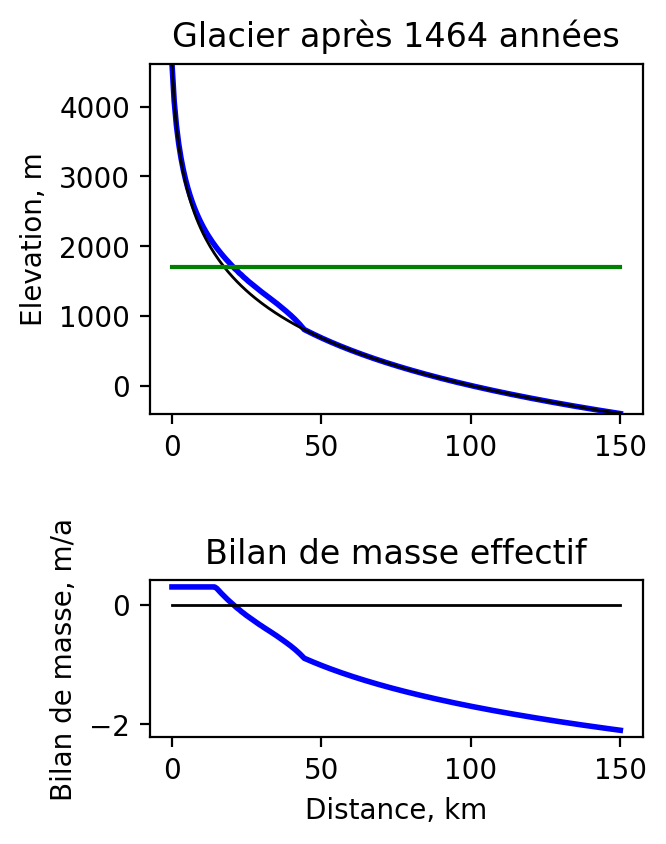

Elapsed time is : 7.370145320892334 s


In [6]:
# Initialize lists to store data for training
data = []

# Time loop
start = time.time()

# Initialize a list to store the volumes and corresponding time values
volume_history = []
time_history = []

while Time < ttot:
    # Get the index of time in the ELA list
    idx = np.where(t == myround(Time))[0].item()

    # Compute dHdt due to diffusion
    H_av = 0.5 * (H[:-1] + H[1:])  # average height between cells (nx-1)
    D = kD * H_av**5 * (torch.diff(Z) / dx)**2  # diffusivity (nx-1)
    qx = -D * torch.diff(Z) / dx  # ice flux

    dHdt = -torch.diff(qx) / dx  # change in ice thickness from flow

    # Update time step as function of D
    max_D = torch.max(D).item()
    dt = min(dtmax, dx**2 / (2.1 * (max_D + epsilon)))  # update time step

    # Update thickness of ice (iceflow)
    H[1:-1] += dt * dHdt  # update ice thickness from flow

    # Update ice thickness (mass balance)
    b = torch.minimum(grad_b * (Z - z_ELA[idx]), torch.tensor(b_max, device=device))
    H[1:-1] += dt * b[1:-1]

    H[H < 0] = 0  # set any negative thickness to 0

    # Boundary conditions
    H[0] = 0
    H[-1] = 0

    Z = Z_bed + H  # update ice surface
    Time += dt  # update time
    it += 1

    # Calculate the volume of the ice
    volume = torch.sum(H * dx).item()  # Integrate H over the domain
    volume_history.append(volume)
    time_history.append(Time)

    # Save observations
    if round(Time) == 1100:
        torch.save(H, 'observed_thk_1100.pt')

    if round(Time) == 1350:
        torch.save(H, 'observed_thk_1350.pt')

    # Call visualization function
    if it % nout == 0:
        visualize_glacier(x, Z, Z_bed, z_ELA[idx], b, Time)

end = time.time()
print(f"Elapsed time is : {end - start} s")

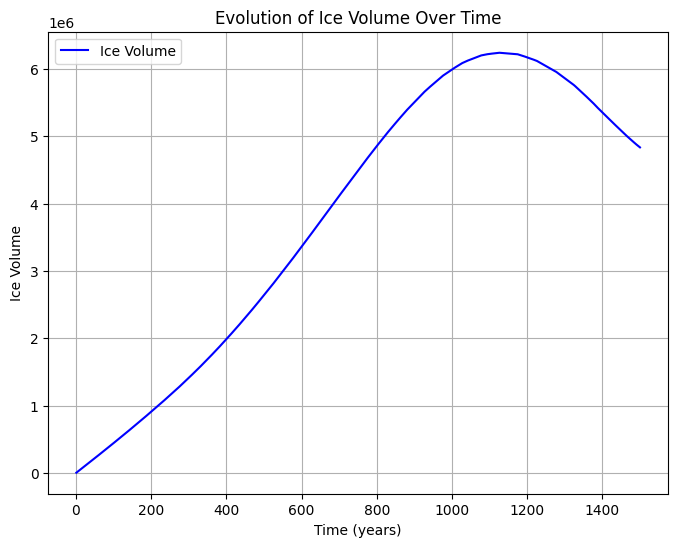

In [7]:
# Plot the volume evolution
plt.figure(figsize=(8, 6))
plt.plot(time_history, volume_history, label="Ice Volume", color='blue')
plt.xlabel("Time (years)")
plt.ylabel("Ice Volume")
plt.title("Evolution of Ice Volume Over Time")
plt.legend()
plt.grid()
plt.show()

In [8]:
# Sav e the observations.
torch.save(H,'observed_thk_1500.pt')


In [16]:
# Function to perform forward simulation of glacier thickness with differentiable operations
def forward_simulation(H_initial,b_max, grad_b,z_ELA, ttot=1e3, device=device,display_time=False):
    start= time.time()
    # Physics constants
    n=3
    rhog = 910 * 9.81  # ice density kg/m^3 * gravity m/s^{-2}
    fd = 1e-15  # physical constant for ice diffusivity, Pa^3/y
    kD = fd * rhog**n  # lump all constants for diffusivity together
    epsilon = 1e-12

    # Numerics
    Lx = 1.5e5  # model length, m
    nx = 201  # number of cells
    dx = Lx / (nx - 1)  # number of cells 
    dtmax = 1      # initial dt, will be changed within loop, yr
    dt    = dtmax  # initial dt, will be changed within loop, yr
    Time = 0

    # Initialization
    x = torch.linspace(0, Lx, nx, device=device)  # x-coordinates
    Z_bed = -1000 * torch.log(x + 1000) + 11522.8  # topography (avoid log(0))
    H = H_initial.clone()  # initial ice thickness
    Z = Z_bed + H  # ice surface

    recorded_1100 = False
    recorded_1350 = False

    while Time < ttot:
        #get the index of time in the ELA list
        idx=np.where(t == myround(Time))[0].item()
        # compute dHdt due to diffusion
        H_av = 0.5 * (H[:-1] + H[1:])  # average height between cells (nx-1)
        D = kD * H_av**5 * (torch.diff(Z) / dx)**(n-1)  # diffusivity (nx-1)
        qx = -D * torch.diff(Z) / dx  # ice flux
        # Compute velocity safely
        dHdt = -torch.diff(qx) / dx  # change in ice thickness from flow
        
        # update time step as function of D
        max_D = torch.max(D).item()
        dt = min(dtmax, dx**2 / (2.1 * (max_D + epsilon)))  # update time step

        # update thickness of ice (iceflow)
        H[1:-1] += dt * dHdt  # update ice thickness from flow
    
        # update ice thickness (mass balance)
        b = torch.minimum(grad_b * (Z - z_ELA[idx]), torch.tensor(b_max, device=device)) 
        b.retain_grad() 
        b.register_hook(reduce_hook)
        
        H[1:-1] += dt * b[1:-1]
        H.retain_grad()
        H.register_hook(reduce_hook)
        H[H < 0] = 0  # set any negative thickness to 0
    
        # Boundary conditions
        H[0] = 0
        H[-1] = 0
    
        Z = Z_bed + H  # update ice surface
        Time += dt  # update time# Call visualization function

        # Save observations
        if not recorded_1100 and round(Time)== 1100:
            H_simulated1 = H.clone()
            recorded_1100= True

        if  not recorded_1350 and round(Time)== 1350:
            H_simulated2 = H.clone()
            recorded_1350=True

    H_simulated3 = H.clone()

    return H_simulated1, H_simulated2, H_simulated3

In [17]:
# Initial guesses for inversion problem
b_max = 0.3
grad_b = 0.001
z_ELA = 1200 + 200 * torch.cos((t / ttot) * 2 * torch.pi)
z_ELA.requires_grad_(True)
# z_ELA = torch.full((len(t),),1200., requires_grad=True, device=device)
# Observed glacier thickness (assumed already loaded as observed_thk tensor)
observed_thk1 = torch.load('observed_thk_1100.pt', weights_only=True).to(device) # Ensure it's on the right device
observed_thk2 = torch.load('observed_thk_1350.pt', weights_only=True).to(device) # Ensure it's on the right device
observed_thk3 = torch.load('observed_thk_1500.pt', weights_only=True).to(device) # Ensure it's on the right device


# Define initial and final learning rates
initial_lr = 7
final_lr = 7
n_iterations = 80

# Optimizer setup
optimizer = torch.optim.Adam([z_ELA], lr=initial_lr)
reg_lambda=0.001

# Initialize lists to track loss components
total_loss_history = []
data_fidelity_history = []
regularization_history = []
total_gradients_history=[]
ELA_evolution=[]

for i in range(n_iterations):
    # Update the learning rate
    lr = initial_lr - (i / (n_iterations - 1)) * (initial_lr - final_lr)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    
    optimizer.zero_grad()  # Zero gradients
    
    # Perform forward simulation
    H_simulated1,H_simulated2,H_simulated3 = forward_simulation(H_initial,b_max, grad_b, z_ELA,ttot=ttot,display_time=False)
    
    # Compute data fidelity and regularization
    data_fidelity1 = torch.mean((H_simulated1 - observed_thk1) ** 2)
    data_fidelity2 = torch.mean((H_simulated2 - observed_thk2) ** 2)
    data_fidelity3 = torch.mean((H_simulated3 - observed_thk3) ** 2)

    smoothness_reg = torch.sum((z_ELA[1:] - z_ELA[:-1]) ** 2)
    
    # Compute total loss
    loss = data_fidelity1 + data_fidelity2 + data_fidelity3 + reg_lambda * smoothness_reg
    # Backpropagate loss and update parameters
    loss.backward()

    total_gradients_history.append(torch.mean(z_ELA.grad).cpu())

    optimizer.step()


    # Store loss components for plotting later
    total_loss_history.append(loss.item())
    data_fidelity_history.append(data_fidelity1.item())
    regularization_history.append((reg_lambda * smoothness_reg).item())

    # Print loss, gradients and current parameters every 50 iterations 
    if (i + 1) % 20 == 0:
        print(f"\nIteration {i+1}/{n_iterations}, Loss: {loss:.3f} ")
        print(f"Gradient of ELA : {torch.mean(z_ELA.grad)} ELA is {torch.mean(z_ELA)} m")

print_gpu_utilization()  # Print memory after the loop
print_peak_gpu_memory()  # Print the peak memory 


Iteration 20/80, Loss: 9927.784 
Gradient of ELA : -0.00154721993021667 ELA is 1223.83935546875 m

Iteration 40/80, Loss: 7692.083 
Gradient of ELA : -0.001332464860752225 ELA is 1247.374755859375 m

Iteration 60/80, Loss: 5425.726 
Gradient of ELA : -0.001381268841214478 ELA is 1278.768798828125 m

Iteration 80/80, Loss: 3628.758 
Gradient of ELA : -0.0011668207589536905 ELA is 1312.307861328125 m
GPU memory occupied: 513 MB.
Peak GPU memory used: 23.32 MB.


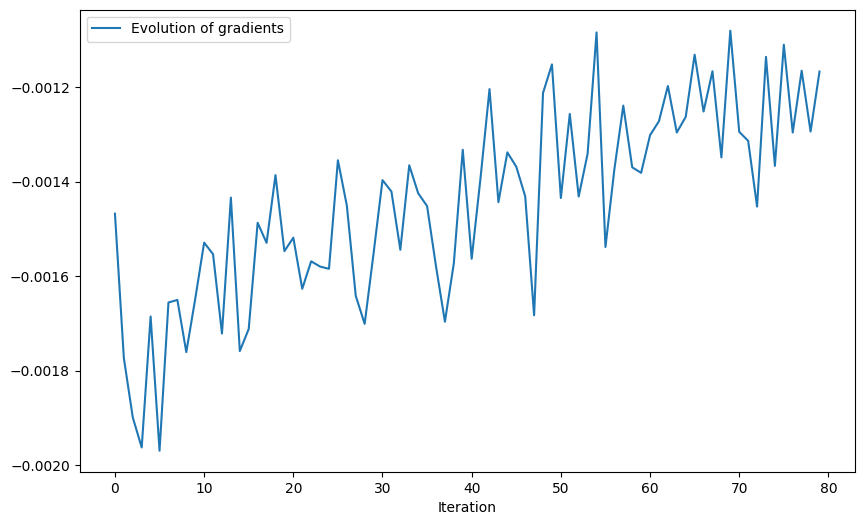

In [18]:
plt.figure(figsize=(10,6))
# plt.plot(ELA_evolution,label="evolution of ELA",color='b')
plt.plot(total_gradients_history, label='Evolution of gradients')
plt.xlabel('Iteration')
plt.legend()
plt.show()

/tmp/ipykernel_51084/17572691.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


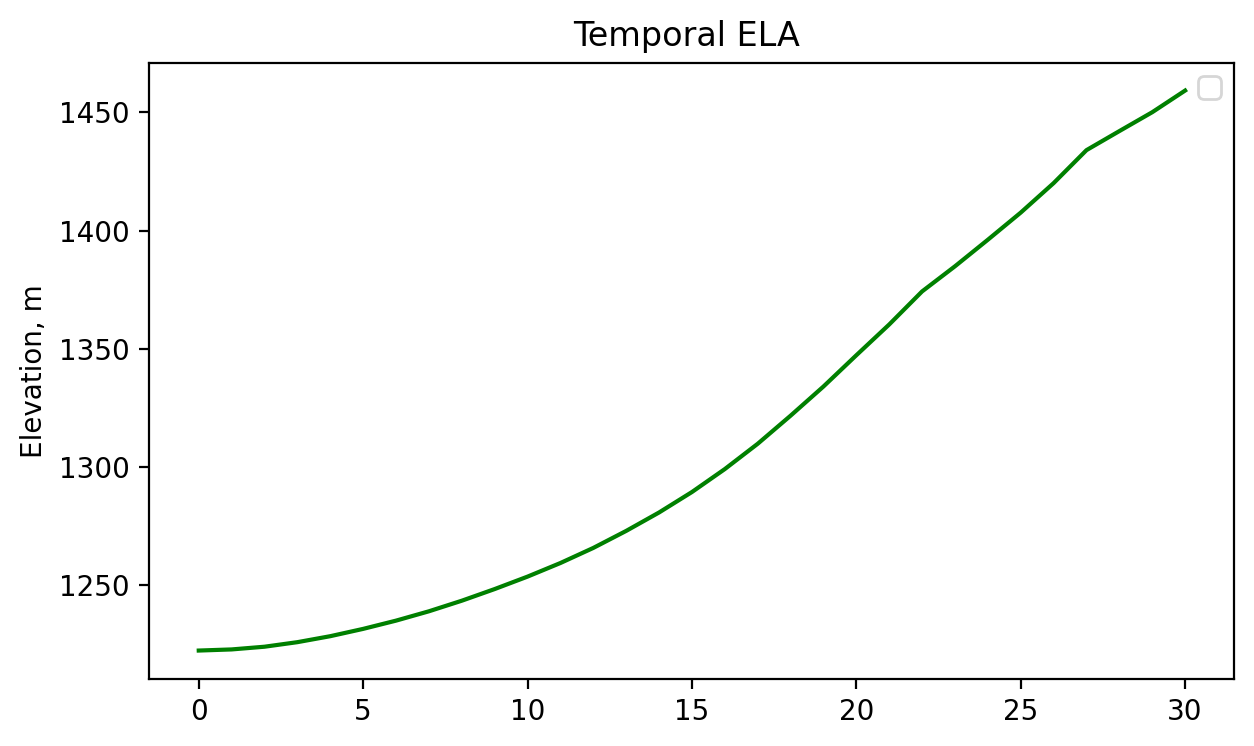

In [19]:
Z_bed_list = Z_bed.cpu().tolist()  # Convert to list
x_list = x.cpu().tolist()  # Convert to list
z_ELA_list=z_ELA.cpu().tolist()
clear_output(wait=False)  # Clear the previous output in the notebook
plt.figure(figsize=(7, 4), dpi=200)

plt.plot(z_ELA_list, 'g')
# plt.ylim([min(Z_bed_list), max(Z_bed_list)])
plt.ylabel('Elevation, m')
plt.title('Temporal ELA ')
plt.legend()
plt.show()

In [20]:
# Function to plot the loss function components
def plot_loss_components(total_loss_history, data_fidelity_history, regularization_history):
    plt.figure(figsize=(10, 6))

    # Plot the total loss, data fidelity, and regularization term
    plt.plot(total_loss_history, label='Total Loss', color='b', linewidth=2)
    plt.plot(data_fidelity_history, label='Data Fidelity', color='g', linestyle='--', linewidth=2)
    plt.plot(regularization_history, label='Regularization (Smoothness)', color='r', linestyle='-.', linewidth=2)

    # Add labels and legend
    plt.xlabel('Iteration')
    plt.ylabel('Loss Value')
    plt.title('Loss Function Components Over Iterations')
    plt.legend()

    # Show the plot
    plt.grid(True)
    plt.tight_layout()
    plt.show()

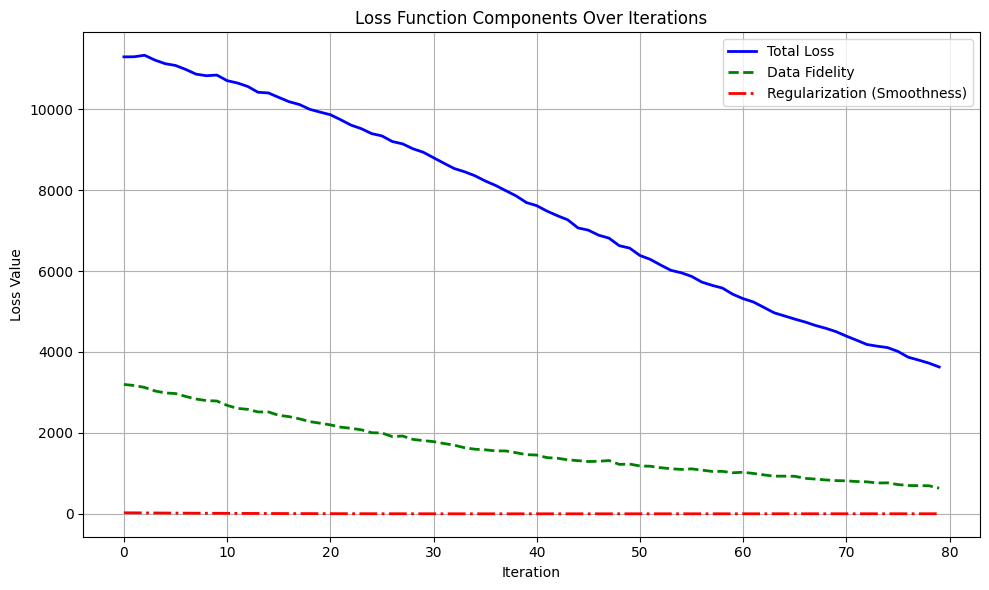

In [21]:
# After the optimization loop
plot_loss_components(total_loss_history, data_fidelity_history, regularization_history)